## Preamble

In [4]:
%load_ext autoreload
%autoreload 0

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
%autoreload

In [6]:
import sys
sys.path.append('/pollard/home/bsmith/Projects/haplo-benchmark/include/StrainFacts')

In [7]:
import xarray as xr
import sqlite3
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import torch
import pyro
import scipy as sp

import lib.plot
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import AgglomerativeClustering
from lib.pandas_util import idxwhere


import sfacts as sf

# from lib.project_style import color_palette, major_allele_frequency_bins
# from lib.project_data import metagenotype_db_to_xarray
# from lib.plot import ordination_plot, mds_ordination, nmds_ordination
# import lib.plot
# from lib.plot import construct_ordered_pallete
# from lib.pandas_util import idxwhere

## Load Data

In [8]:
fit = sf.data.World.load('data/zshi.sp-102492.metagenotype.filt-poly05-cvrg25.fit-sfacts13-s500-g500-seed3.world.nc')
fit.sizes

Frozen(SortedKeysDict({'strain': 286, 'sample': 11860, 'position': 3681, 'allele': 2}))

In [9]:
ref = sf.data.Metagenotypes.load('data/gtprodb.sp-102492.genotype.nc').mlift('sel', position=fit.position).to_estimated_genotypes(pseudo=0)
ref.sizes

Frozen({'strain': 1000, 'position': 3681})

/opt/conda/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log2
  result_data = func(*input_data)


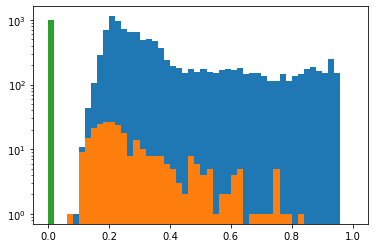

In [10]:
bins = np.linspace(0, 1, num=51)

plt.hist(fit.metagenotypes.to_estimated_genotypes(pseudo=1e-3).entropy(), bins=bins)
plt.hist(fit.genotypes.entropy(), bins=bins)
plt.hist(ref.entropy(), bins=bins)

plt.yscale('log')
None

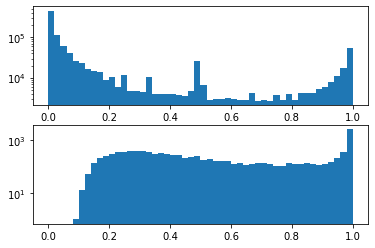

In [11]:
bins = np.linspace(0, 1, num=51)

fig, axs = plt.subplots(2)
axs[0].hist(fit.genotypes.values.flatten(), bins=bins)
axs[1].hist(fit.communities.max("strain").values.flatten(), bins=bins)

for ax in axs:
    ax.set_yscale('log')
None

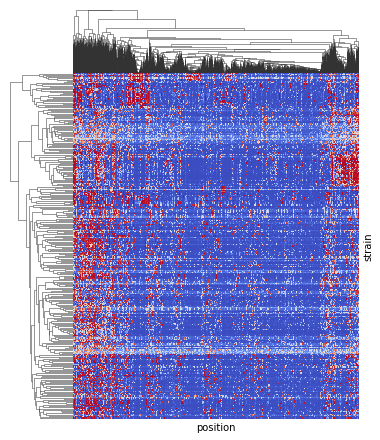

In [12]:
sf.plot.plot_genotype(fit, scaley=2e-2, scalex=1e-3, yticklabels=0)

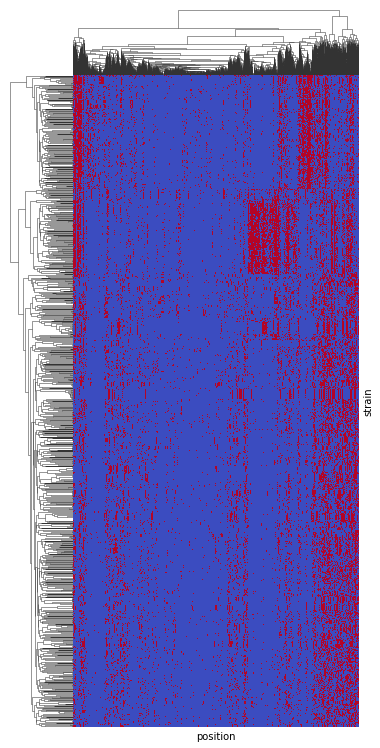

In [13]:
sf.plot.plot_genotype(ref, scaley=1e-2, scalex=1e-3, yticklabels=0)

In [14]:
fit_genotypes_filt = fit.genotypes.mlift('sel', strain=fit.genotypes.entropy() < 0.25)
fit_genotypes_highent = fit.genotypes.mlift('sel', strain=fit.genotypes.entropy() > 0.25)

fit_genotypes_filt.sizes, fit_genotypes_highent.sizes

(Frozen({'strain': 160, 'position': 3681}),
 Frozen({'strain': 126, 'position': 3681}))

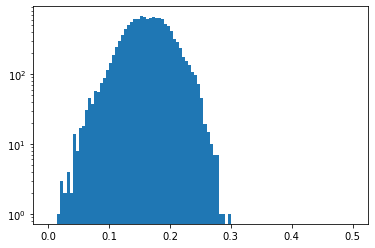

In [15]:
plt.hist(squareform(fit_genotypes_filt.pdist()), bins=np.linspace(0, 0.5, num=101))
plt.yscale('log')
None

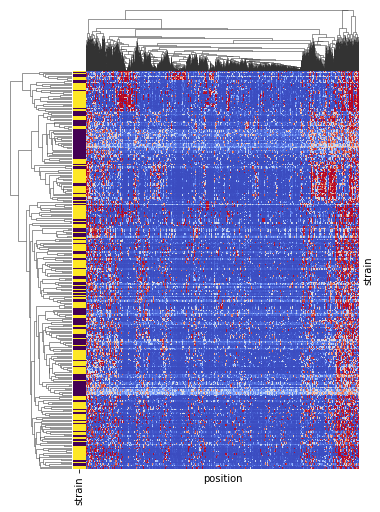

In [16]:
g = sf.data.Genotypes.concat(dict(
    bad=fit_genotypes_highent,
    good=fit_genotypes_filt
), dim='strain')


sf.plot.plot_genotype(g, row_colors_func=lambda w: w.strain.str.startswith('good'), scaley=2e-2, scalex=1e-3, yticklabels=0)

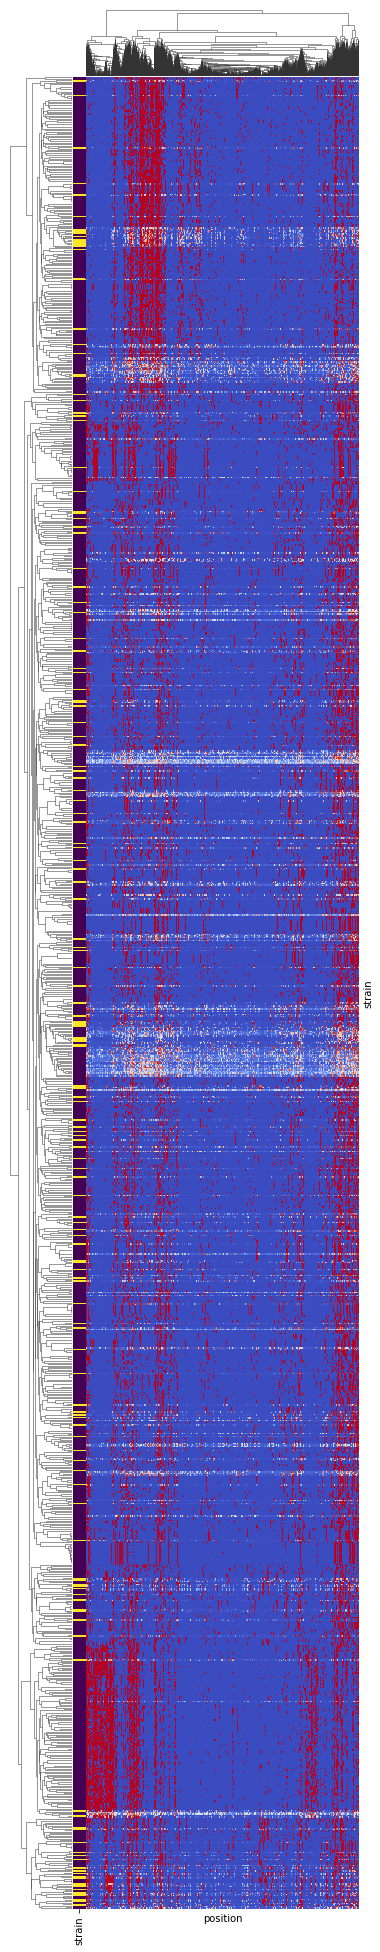

In [17]:
g = sf.data.Genotypes.concat(dict(
    ref=ref,
    fit=fit_genotypes_filt,
    ent=fit_genotypes_highent,
), dim='strain')


sf.plot.plot_genotype(g, row_colors_func=lambda w: w.strain.str.startswith('fit'), scaley=2e-2, scalex=1e-3, yticklabels=0)

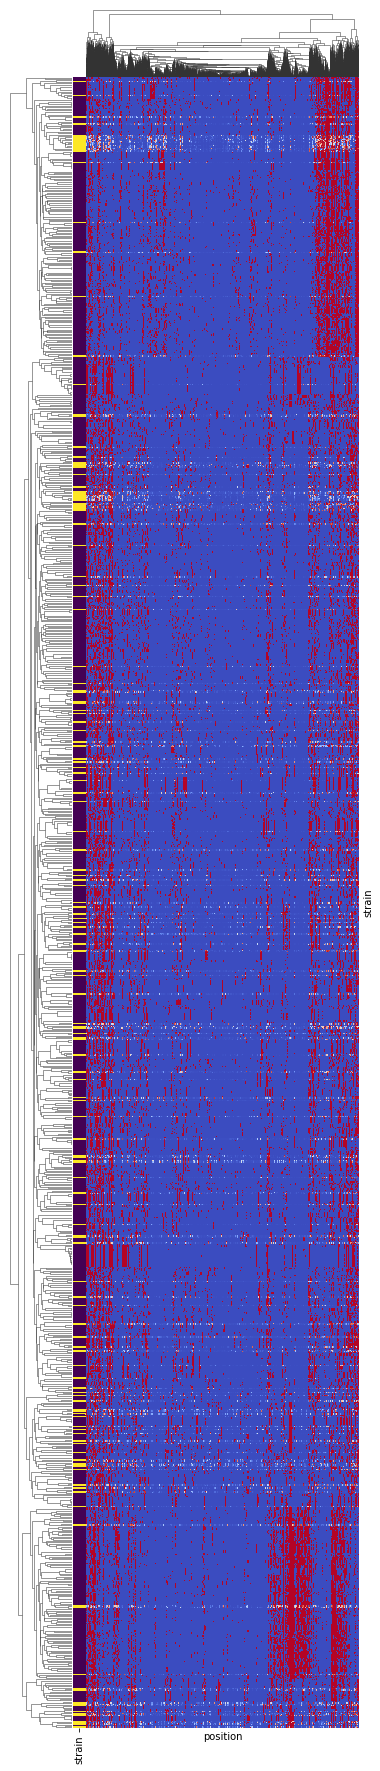

In [18]:
g = sf.data.Genotypes.concat(dict(
    ref=ref,
    fit=fit_genotypes_filt,
), dim='strain')


sf.plot.plot_genotype(g, row_colors_func=lambda w: w.strain.str.startswith('fit'), scaley=2e-2, scalex=1e-3, yticklabels=0)

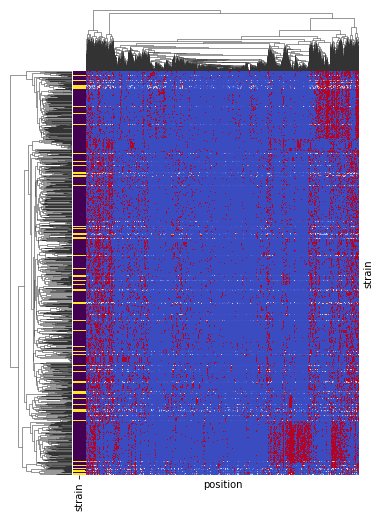

In [209]:
g = sf.data.Genotypes.concat(dict(
    ref=ref,
    fit=fit_genotypes_filt,
), dim='strain')


sf.plot.plot_genotype(g, row_colors_func=lambda w: w.strain.str.startswith('fit'), scaley=5e-3, scalex=1e-3, yticklabels=0)

In [20]:
position_meta = pd.read_table(
    'ref/gtpro/variants_main.covered.hq.snp_dict.tsv',
    names=['species_id', 'position', 'contig', 'contig_position', 'ref', 'alt']
).set_index('position')[lambda x: x.species_id.isin([102492])]

position_meta

,species_id,contig,contig_position,ref,alt
position,,,,,
14092,102492,.12718_7_53.1,14092,A,G
14137,102492,.12718_7_53.1,14137,T,C
14668,102492,.12718_7_53.1,14668,A,G
15562,102492,.12718_7_53.1,15562,T,C
15564,102492,.12718_7_53.1,15564,C,T
...,...,...,...,...,...
3454569,102492,.12718_7_53.57,7365,A,C
3454572,102492,.12718_7_53.57,7368,C,G
3455438,102492,.12718_7_53.57,8234,G,A


In [204]:
ref_diss = ref.pdist("strain")
ref_clust = AgglomerativeClustering(n_clusters=None, distance_threshold=0.02, affinity='precomputed', linkage='complete').fit_predict(ref_diss)
ref_clust = pd.Series(ref_clust, index=ref_diss.index)
ref_clust.value_counts()

3      11
101     6
38      6
139     5
29      5
       ..
357     1
358     1
359     1
360     1
785     1
Length: 786, dtype: int64

In [205]:
ref_agg = sf.data.Genotypes(
    ref.data.to_dataframe().join(ref_clust.rename("clust")).reset_index().groupby(["clust", "position"]).mean().rename_axis(index=dict(clust='strain')).squeeze().to_xarray()
)

In [206]:
ld = {}
for contig, pos in position_meta.loc[ref_agg.position].groupby('contig'):
    print(contig)
    g = ref_agg.sel(position=pos.index)
    r2 = (1 - pdist(g.values.T, 'correlation'))**2
    x = pdist(np.expand_dims(pos.contig_position.values, axis=1), 'cityblock')
    ld[contig] = (x, r2)
ref_ld = pd.DataFrame(np.concatenate([np.stack([x, r2], axis=1) for x, r2 in ld.values()]), columns=['x', 'r2'])

.12718_7_53.1
.12718_7_53.11
.12718_7_53.13
.12718_7_53.14
.12718_7_53.15
.12718_7_53.16
.12718_7_53.2
.12718_7_53.21
.12718_7_53.23
.12718_7_53.24
.12718_7_53.25
.12718_7_53.26
.12718_7_53.27
.12718_7_53.28
.12718_7_53.29
.12718_7_53.3
.12718_7_53.32
.12718_7_53.34
.12718_7_53.37
.12718_7_53.4
.12718_7_53.40
.12718_7_53.57
.12718_7_53.6
.12718_7_53.7
.12718_7_53.8
.12718_7_53.9


In [195]:
est_diss = fit_genotypes_filt.pdist("strain")
est_clust = AgglomerativeClustering(n_clusters=None, distance_threshold=0.1, affinity='precomputed', linkage='complete').fit_predict(est_diss)
est_clust = pd.Series(est_clust, index=est_diss.index)
est_clust.value_counts()

18     11
0       9
11      4
1       3
9       3
       ..
53      1
51      1
50      1
49      1
107     1
Length: 108, dtype: int64

In [196]:
est_agg = sf.data.Genotypes(
    fit_genotypes_filt.data.to_dataframe().join(est_clust.rename("clust")).reset_index().groupby(["clust", "position"]).mean().genotypes.rename_axis(index=dict(clust='strain')).to_xarray()
)

In [197]:
ld = {}
for contig, pos in position_meta.loc[est_agg.position].groupby('contig'):
    print(contig)
    g = est_agg.sel(position=pos.index)
    r2 = (1 - pdist(g.values.T, 'correlation'))**2
    x = pdist(np.expand_dims(pos.contig_position.values, axis=1), 'cityblock')
    ld[contig] = (x, r2)
est_ld = pd.DataFrame(np.concatenate([np.stack([x, r2], axis=1) for x, r2 in ld.values()]), columns=['x', 'r2'])

.12718_7_53.1
.12718_7_53.11
.12718_7_53.13
.12718_7_53.14
.12718_7_53.15
.12718_7_53.16
.12718_7_53.2
.12718_7_53.21
.12718_7_53.23
.12718_7_53.24
.12718_7_53.25
.12718_7_53.26
.12718_7_53.27
.12718_7_53.28
.12718_7_53.29
.12718_7_53.3
.12718_7_53.32
.12718_7_53.34
.12718_7_53.37
.12718_7_53.4
.12718_7_53.40
.12718_7_53.57
.12718_7_53.6
.12718_7_53.7
.12718_7_53.8
.12718_7_53.9


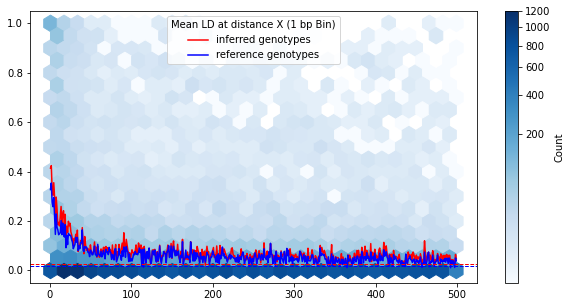

In [210]:
stepsize = 1
right = 500

d = est_ld[lambda p: p.x < right]
bins_est = {}
for start in range(0, right, stepsize):
    stop = start + stepsize
    bins_est[start] = d[(d.x >= start) & (d.x < stop)].r2.mean()
    
    
d = ref_ld[lambda p: p.x < right]
bins_ref = {}
for start in range(0, right, stepsize):
    stop = start + stepsize
    bins_ref[start] = d[(d.x >= start) & (d.x < stop)].r2.mean()


fig = plt.figure(figsize=(10, 5))

plt.hexbin('x', 'r2', data=d, cmap='Blues', norm=mpl.colors.PowerNorm(1/3), mincnt=1, gridsize=(30, 10), label='__nolegend__')
plt.colorbar(label='Count')

ax = plt.gca()

ax.plot(pd.Series(bins_est), color='red', label=f'inferred genotypes')
ax.plot(pd.Series(bins_ref), color='blue', label=f'reference genotypes')
ax.axhline(est_ld.r2.mean(), lw=1, color='red', linestyle='--')
ax.axhline(ref_ld.r2.mean(), lw=1, color='blue', linestyle='--')

ax.legend(title=f'Mean LD at distance X ({stepsize} bp Bin)')  #bbox_to_anchor=(0.85, 1.15), ncol=2)